Need to test performance of frequency grid algorithms... 
Specifically, compare Ivezic+2014 (Yellow book),  E.Bellm, and astropy  autofrequency  : 
building on 
    10.2016_Chapter_10_calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/S82analysis/packages/')
import frequencyFunctions as freq
import imp
imp.reload(freq)

<module 'frequencyFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/S82analysis/packages/frequencyFunctions.py'>

In [3]:
from astropy.stats import LombScargle

# simulate random observation times 
stor = {}
stor['AstroML'] = {}
stor['EricB'] = {}
stor['AstroPy'] = {}
stor['AstroPy2'] = {}

N_arr = np.arange(10,150,10)

for key in stor.keys():
    stor[key]['N'] = N_arr
    stor[key]['OmegaMin'] = np.zeros_like(N_arr, dtype=float)
    stor[key]['OmegaMax'] = np.zeros_like(N_arr,dtype=float)
    stor[key]['Nbins'] = np.zeros_like(N_arr,dtype=float)
    
i=0    
for N in N_arr:
    t_max = 100
    t_obs = t_max * np.random.random(N)

    omegas = freq.frequency_grid(t_obs, method = 'AstroPy')

    stor['AstroPy']['OmegaMin'][i] = min(omegas)
    stor['AstroPy']['OmegaMax'][i] = max(omegas)
    stor['AstroPy']['Nbins'][i] = len(omegas)

    omegas = freq.frequency_grid(t_obs, method = 'AstroML')
    stor['AstroML']['OmegaMin'][i] = min(omegas)
    stor['AstroML']['OmegaMax'][i] = max(omegas)
    stor['AstroML']['Nbins'][i] = len(omegas)

    omegas = freq.frequency_grid(t_obs, method = 'EBellm')
    stor['EricB']['OmegaMin'][i] = min(omegas)
    stor['EricB']['OmegaMax'][i] = max(omegas)
    stor['EricB']['Nbins'][i] = len(omegas)
    
    # SANITY check  : compare 'my implementation' AstroPy 
    # to actual AstroPy autofrequency .
    # If all works well, I expect them  to be identical  
    y = np.random.random(len(t_obs))
    # note !   Astropy returns f,  not omega!!!!! 
    fs = LombScargle(t_obs, y).autofrequency()
    omegas = fs * 2 * np.pi 
    stor['AstroPy2']['OmegaMin'][i] = min(omegas)
    stor['AstroPy2']['OmegaMax'][i] = max(omegas)
    stor['AstroPy2']['Nbins'][i] = len(omegas)
    
    i += 1 

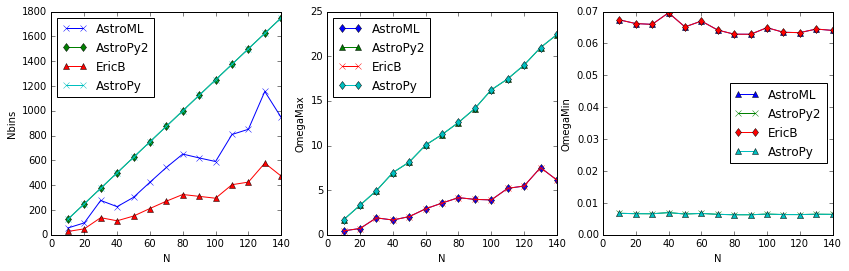

In [4]:
%matplotlib inline

xval = 'N'
from itertools import cycle
lines = ["--","-.",":"]
linecycler = cycle(lines)

markers = ['x', 'd', '^']
markercycler = cycle(markers)

fig,ax = plt.subplots(1,3, figsize=(14,4))
for i in range(3):
    yval = np.sort(list(stor['AstroML'].keys()))[i+1]
    j = 0
    for key in  stor.keys(): # ['Astropy', 'Astropy2'] :
        ax[i].plot(stor[key][xval], stor[key][yval], label=key, marker = next(markercycler))
        
        ax[i].set_xlabel(xval)
        ax[i].set_ylabel(yval)
        j += 1 
    ax[i].legend(loc = 'best')
    
plt.savefig('../data_products/12-03-16_compare_frequency_grids.png')



**AstroPy:**
S : samples per peak (set to 5),  $y_{F}$ : Nyquist factor (set to 5) 

$\Delta T = abs(t_{max} - t_{min})$ : baseline 

$N = length(t) $ : number of points (sample size)

$df = \frac{1}{\Delta T \cdot S}$

$f_{min} = 0.5 df = \frac{1}{\Delta T} \frac{1}{2S}$

$f_{max} = f_{min} + N_{bins} \cdot df  = f_{min} + \frac{y_{F} N}{2\Delta T}$

$N_{bins} = \frac{1}{2} N \cdot S \cdot y_{F}$

**AstroML:**

$f_{min} = \frac{1}{\Delta T}$

$f_{max} = \frac{1}{2} median(\frac{1}{\Delta t})$

$df = 0.1 f_{min}$

$N_{bins} = (1/df) * (f_{max} - f_{min}) = 5 \cdot median(\frac{1}{\Delta t}) \cdot \Delta T - 10$ 

**E.Bellm **

$f_{min} = \frac{1}{\Delta T}$       (same as AstroML)

$f_{max} = \frac{1}{2} \frac{1}{median(\Delta t)}$ (slightly different to AstroML, turns out to be actually identical...)

$df = 0.2 f_{min}$

$N_{bins} = (1/df) * (f_{max} - f_{min})  = 2.5  \frac{1}{median(\Delta t)} \Delta T - 5$ (slight difference )

Below : raw implementation of equations above.  As of 01/13/2017,  all of that is part of 
frequencyFunctions.py 

In [15]:
N_arr

array([ 5, 65])

In [16]:
# simulate random observation times 
store = {}
store['AstroML'] = {}
store['EBellm'] = {}
store['AstroPy'] = {}

N_arr = np.arange(5,100,1)

for key in store.keys():
    store[key]['N'] = N_arr
    store[key]['OmegaMin'] = np.zeros_like(N_arr, dtype=float)
    store[key]['OmegaMax'] = np.zeros_like(N_arr,dtype=float)
    store[key]['Nbins'] = np.zeros_like(N_arr,dtype=float)
    
time_series = {}
time_series['median_dt'] = np.zeros_like(N_arr,dtype=float)
time_series['baseline'] = np.zeros_like(N_arr, dtype=float)

t_max = 100    
for i in range(len(N_arr)): 
    N = N_arr[i]   

    times = t_max * np.random.random(N)
    times = np.sort(times)
    baseline = abs(min(times) - max(times))

    delta_t  = np.zeros(len(times)-1) 
    for j in range(len(times)-1):
        delta_t[j] = (times[j+1]-times[j])
        
    time_series['median_dt'][i] = np.median(delta_t)
    time_series['baseline'][i] = baseline
    
    #print('baseline=%f'%baseline)
    #print('median(delta_t)%f'%np.median(delta_t))
    #print('baseline / median(delta_t) = %f'% (baseline / np.median(delta_t)))
    #print('[2 * baseline / median(delta_t)  - 4] / (5 N) = %f'% ((2 * (baseline / np.median(delta_t)) - 4)/(5*N)))
    #AstroPy
    S = 5
    yF = 5
    f_min = 1.0 / (2 * S * baseline)
    f_max = f_min + ( yF * N ) / (2 * baseline)
    N_bins = 0.5 * N * S * yF 
    store['AstroPy']['OmegaMin'][i] = f_min * 2 * np.pi 
    store['AstroPy']['OmegaMax'][i] = f_max * 2 * np.pi
    store['AstroPy']['Nbins'][i] = int(N_bins)
    
    #AstroML
    f_min = 1.0 / baseline
    f_max = 0.5 * np.median(1.0 / delta_t)
    N_bins = 5 * np.median(1.0 / delta_t) * baseline - 10 
    store['AstroML']['OmegaMin'][i] = f_min * 2 * np.pi 
    store['AstroML']['OmegaMax'][i] = f_max * 2 * np.pi
    store['AstroML']['Nbins'][i] = int(N_bins)
    
    # E. Bellm
    f_min = 1.0 / baseline
    f_max = 0.5 / np.median(delta_t)
    N_bins = 2.5 * (baseline / np.median(delta_t)) - 5 
    store['EBellm']['OmegaMin'][i] = f_min * 2 * np.pi 
    store['EBellm']['OmegaMax'][i] = f_max * 2 * np.pi
    store['EBellm']['Nbins'][i] = int(N_bins)

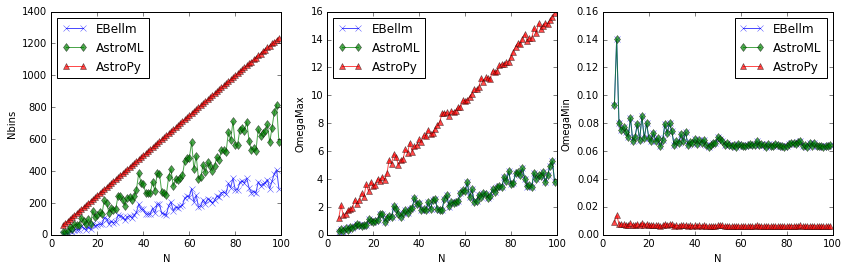

In [17]:
%matplotlib inline

xval = 'N'
fig,ax = plt.subplots(1,3, figsize=(14,4))

from itertools import cycle
lines = ["--","-.",":"]
linecycler = cycle(lines)

markers = ['x', 'd', '^']
markercycler = cycle(markers)

colors  = ['b','g','r']
colorcycler = cycle(colors)

for i in range(3):
    yval = np.sort(list(store['AstroML'].keys()))[i+1]
    j = 0 
    for key in store.keys():
        ax[i].plot(store[key][xval], store[key][yval], label=key, marker=next(markercycler), 
                      alpha=0.7, color=next(colorcycler)) #ls=next(linecycler) 
         
        ax[i].set_xlabel(xval)
        ax[i].set_ylabel(yval)
        j +=1 
    ax[i].legend(loc = 'best')
plt.savefig('../data_products/12-03-16_compare_frequency_grids_theory.png')

Increase the OmegaMax for small number of points for AstroPy :

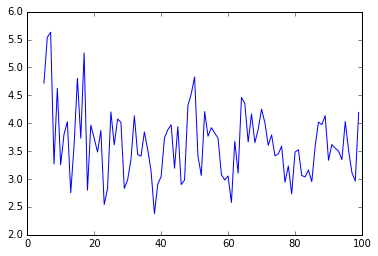

In [18]:
diff = store['AstroPy']['OmegaMax']  / store['AstroML']['OmegaMax']

plt.plot(store['AstroPy']['N'], diff )  

In [21]:
def func(x, a, b):
    return a * x + b

from scipy.optimize import curve_fit
# popt is func(x, popt*)

# max_point 
max_point = 30 
x = [5,max_point]
y = [5,1]
popt, pcov = curve_fit(func, x, y)
a,b = popt[0], popt[1]
print('a= %f, b=%f'%(a,b))

omega_corr = a * np.arange(max_point) + b 
omega_corr

a= -0.160000, b=5.800000


/Users/chris/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([ 5.8 ,  5.64,  5.48,  5.32,  5.16,  5.  ,  4.84,  4.68,  4.52,
        4.36,  4.2 ,  4.04,  3.88,  3.72,  3.56,  3.4 ,  3.24,  3.08,
        2.92,  2.76,  2.6 ,  2.44,  2.28,  2.12,  1.96,  1.8 ,  1.64,
        1.48,  1.32,  1.16])

In [ ]:
# I make a lookup table for values of N  smaller than 20 : this is where the higher frequency search seems really needed 

dx = 0.25 
a = - 3 / 16.0
b = 1+  60 / 16.0

N = np.arange(21)
omega_correction = a * N + b 

if N_pts < 20 : 
    omega_max = omega_correction[N_pts] * omega_max 

In [153]:
# tiny difference here is between
#  n_bins = int(n * (f_max - f_min) / f_min)
# where n=10 or 5 for AstroML vs EBellm 
#  and 
#  n_bins = m(2.5 * (baseline / np.median(delta_t)) - 5)
#  where m=2 or 1 for AstroML vs EBellm 
# 
key = 'OmegaMin'
implementation = 'AstroPy'
print(store[implementation][key])
print(stor[implementation][key])

[ 0.00816936  0.00674042  0.00640707  0.0064025   0.00642217  0.0064014
  0.00642583  0.0065019   0.00638755  0.00635905  0.00638059  0.0063042
  0.00633957  0.00634323]
[ 0.00765449  0.00658592  0.0067823   0.00649335  0.00684902  0.00657472
  0.00634723  0.00658938  0.00639795  0.00645196  0.00635544  0.00632376
  0.00649271  0.00635744]


In [150]:
stor['AstroPy']['Nbins']

array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
        1125.,  1250.,  1375.,  1500.,  1625.,  1750.])

In [49]:
for key in store['AstroML'].keys():
    print('AstroML %s / AstroPy %s:'%(key,key))
    print(store['AstroML'][key] / store['AstroPy'][key])

AstroML Nbins / AstroPy Nbins:
[ 0.39634972  0.39541095  0.77309638  0.42312792  0.48204658  0.49511636
  0.61855239  0.50293708  0.54036172  0.58575028  0.53204772  0.57581398
  0.52616541  0.65519849]
AstroML N / AstroPy N:
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
AstroML OmegaMax / AstroPy OmegaMax:
[ 0.23722596  0.21727094  0.39934906  0.22134262  0.24882423  0.25405548
  0.31481059  0.25634037  0.2745033   0.29675644  0.2695622   0.29114328
  0.26607776  0.330362  ]
AstroML OmegaMin / AstroPy OmegaMin:
[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]


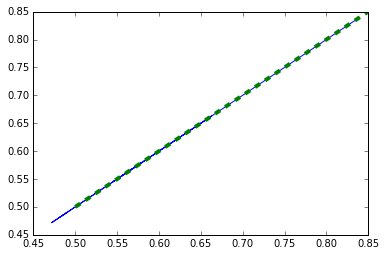

In [76]:
# N bins relation : the formula works...
key = 'Nbins'
ratio = ( 2 * time_series['baseline'] / time_series['median_dt'] - 4.0 ) / (5 * store['AstroML']['N'])
plt.plot(store['AstroML'][key] / store['AstroPy'][key], ratio)
x=np.linspace(0.5,0.85,100)
plt.plot(x,x, ls='--', lw=4)

In [73]:
store['AstroML'][key] / store['EBellm'][key]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [74]:
key = 'OmegaMin'
store['AstroML'][key] / store['AstroPy'][key]

array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.])

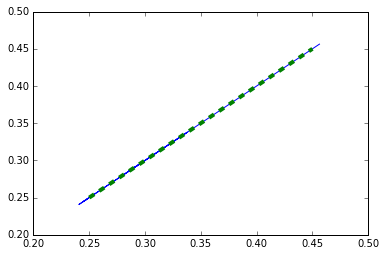

In [79]:
# OmegaMax formula... 
key = 'OmegaMax'
store['AstroML'][key] / store['AstroPy'][key]


ratio = ( time_series['baseline'] * 5 ) / ( time_series['median_dt'] * (1 + 5*5*store['AstroPy']['N']))
plt.plot(store['AstroML'][key] / store['AstroPy'][key] , ratio)
x = np.linspace(0.25, 0.45, 100)
plt.plot(x,x, ls=  '--', lw =4 )

In [166]:
# Simulate different baselines, keeping $N$ fixed at 100 


# simulate random observation times 
store = {}
store['AstroML'] = {}
store['EBellm'] = {}
store['AstroPy'] = {}

T_arr = np.arange(100,1500,100)

for key in store.keys():
    store[key]['baseline'] = T_arr
    store[key]['OmegaMin'] = np.zeros_like(N_arr, dtype=float)
    store[key]['OmegaMax'] = np.zeros_like(N_arr,dtype=float)
    store[key]['Nbins'] = np.zeros_like(N_arr,dtype=float)
    
time_series = {}
time_series['median_dt'] = np.zeros_like(N_arr,dtype=float)
time_series['baseline'] = np.zeros_like(N_arr, dtype=float)

N = 100 
   
for i in range(len(T_arr)): 
      
    t_max = T_arr[i]
    times = t_max * np.random.random(N)
    times = np.sort(times)
    baseline = abs(min(times) - max(times))

    delta_t  = np.zeros(len(times)-1) 
    for j in range(len(times)-1):
        delta_t[j] = (times[j+1]-times[j])
        
    time_series['median_dt'][i] = np.median(delta_t)
    time_series['baseline'][i] = baseline
    
    #print('baseline=%f'%baseline)
    #print('median(delta_t)%f'%np.median(delta_t))
    #print('baseline / median(delta_t) = %f'% (baseline / np.median(delta_t)))
    #print('[2 * baseline / median(delta_t)  - 4] / (5 N) = %f'% ((2 * (baseline / np.median(delta_t)) - 4)/(5*N)))
    #AstroPy
    S = 5
    yF = 5
    f_min = 1.0 / (2 * S * baseline)
    f_max = f_min + ( yF * N ) / (2 * baseline)
    N_bins = 0.5 * N * S * yF 
    store['AstroPy']['OmegaMin'][i] = f_min * 2 * np.pi 
    store['AstroPy']['OmegaMax'][i] = f_max * 2 * np.pi
    store['AstroPy']['Nbins'][i] = int(N_bins)
    
    #AstroML
    f_min = 1.0 / baseline
    f_max = 0.5 * np.median(1.0 / delta_t)
    N_bins = 5 * np.median(1.0 / delta_t) * baseline - 10 
    store['AstroML']['OmegaMin'][i] = f_min * 2 * np.pi 
    store['AstroML']['OmegaMax'][i] = f_max * 2 * np.pi
    store['AstroML']['Nbins'][i] = int(N_bins)
    
    # E. Bellm
    f_min = 1.0 / baseline
    f_max = 0.5 / np.median(delta_t)
    N_bins = 2.5 * (baseline / np.median(delta_t)) - 5 
    store['EBellm']['OmegaMin'][i] = f_min * 2 * np.pi 
    store['EBellm']['OmegaMax'][i] = f_max * 2 * np.pi
    store['EBellm']['Nbins'][i] = int(N_bins)

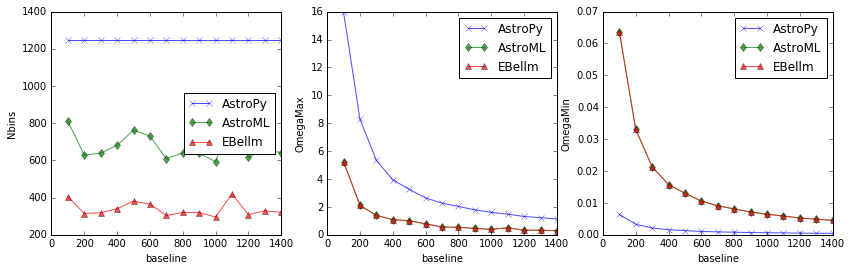

In [169]:
%matplotlib inline

xval = 'baseline'
fig,ax = plt.subplots(1,3, figsize=(14,4))

from itertools import cycle
lines = ["--","-.",":"]
linecycler = cycle(lines)

markers = ['x', 'd', '^']
markercycler = cycle(markers)

colors  = ['b','g','r']
colorcycler = cycle(colors)

for i in range(3):
    yval = np.sort(list(store['AstroML'].keys()))[i]
    j = 0 
    for key in store.keys():
        ax[i].plot(store[key][xval], store[key][yval], label=key, marker=next(markercycler), 
                      alpha=0.7, color=next(colorcycler)) #ls=next(linecycler) 
         
        ax[i].set_xlabel(xval)
        ax[i].set_ylabel(yval)
        j +=1 
    ax[i].legend(loc = 'best')
plt.savefig('../data_products/12-03-16_compare_frequency_grids_baselines.png')